<a href="https://colab.research.google.com/github/ANANTHMANOJ/phenmonia_eda/blob/master/RSNA_model_2_60_epocjs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pydicom

     |████████████████████████████████| 35.5MB 90kB/s 


In [77]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pydicom as dicom
import os
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pickle
import cv2 as cv
from concurrent.futures import ProcessPoolExecutor
import csv
import random
import keras
import pydicom
import shutil
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [3]:
tf.__version__

'2.3.0'

In [4]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/phemonia_capstone_eda/'
os.chdir(path)

Mounted at /content/drive


In [6]:
ls

assets/                rsna-pneumonia-detection-challenge.zip  saved_model_2/
CapstoneProject.ipynb  saved_model/                            variables/
data@                  saved_model_1/


In [7]:
!unzip '/content/drive/My Drive/phemonia_capstone_eda/rsna-pneumonia-detection-challenge.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: /content/stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: /content/stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: /content/stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: /content/stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: /content/stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: /content/stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: /content/stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: /content/stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: /content/stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: /content/stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  i

In [8]:
path='/content/'
os.chdir(path)

In [9]:
ls

 drive/                                 stage_2_sample_submission.csv
'GCP Credits Request Link - RSNA.txt'   stage_2_test_images/
 sample_data/                           stage_2_train_images/
 stage_2_detailed_class_info.csv        stage_2_train_labels.csv


In [10]:
pneumonia_locations = {}
# load table
with open('/content/stage_2_train_labels.csv', mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [11]:
# load and shuffle filenames
folder = '/content/stage_2_train_images'
filenames = os.listdir(folder)
len(filenames)

26684

In [12]:
#shutil.rmtree('/content/test_data')
os.mkdir('/content/test_data')
os.mkdir('/content/train_data')

In [15]:
keys = pneumonia_locations.keys()
list1= list()
for i in keys:
  list1.append(i)
len(list1)

for i in range(3006):
  pn_file= list1[i] + '.dcm'
  shutil.move(os.path.join(folder,pn_file),'/content/train_data')

for i in range(3006,6012):
  pn_file= list1[i] + '.dcm'
  shutil.move(os.path.join(folder,pn_file),'/content/test_data')
  


In [16]:
lt=os.listdir(path+'/stage_2_train_images')
i=0
for fily in lt:
  #pn_file= i
  shutil.move(os.path.join(folder,fily),'/content/train_data')
  i+=1
  if(i>=3006):
    break


In [17]:
lt=os.listdir(path+'/stage_2_train_images')
i=0
for fily in lt:
  #pn_file= i
  shutil.move(os.path.join(folder,fily),'/content/test_data')
  i+=1
  if(i>=3006):
    break

In [18]:
len(os.listdir('/content/train_data'))

6012

In [19]:
len(os.listdir('/content/test_data'))

6012

In [20]:
'''
# load and shuffle filenames
folder = '/content/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

'''

train_filenames = os.listdir('/content/train_data')
valid_filenames = os.listdir('/content/test_data')
n_valid_samples = len(train_filenames)
n_train_samples = len(valid_filenames)



In [21]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                               
                #msk[y:y+h+1,x:x+1]=1
                #msk[y:y+1,x:x+w+1]=1
                #msk[y:y+h+1,x+w:x+w+1]=1
                #msk[y+h:y+h+1,x:x+w+1]=1
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = cv2.resize(img, (self.image_size, self.image_size))
        msk = cv2.resize(msk, (self.image_size, self.image_size)) 
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    

        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        # load files
        items = [self.__load__(filename) for filename in filenames]
        # unzip images and masks
        imgs, msks = zip(*items)
        # create numpy batch
        imgs = np.array(imgs)
        msks = np.array(msks)
        return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [22]:
import tensorflow as tf
def dice_coefficient(y_true, y_pred):
    numr = 2 * tf.reduce_sum(y_true*y_pred)
    denom = tf.reduce_sum(y_pred + y_true) 
    return numr/(denom + tf.keras.backend.epsilon())



from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def img_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [23]:
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

In [24]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,LeakyReLU,UpSampling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,  confusion_matrix
from keras.callbacks import ReduceLROnPlateau

In [78]:
def model(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [68]:
'''
# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss= iou_bce_loss,
              metrics=['accuracy', mean_iou])
'''

"\n# create network and compiler\nmodel = create_network(input_size=256, channels=32, n_blocks=2, depth=4)\nmodel.compile(optimizer='adam',\n              loss= iou_bce_loss,\n              metrics=['accuracy', mean_iou])\n"

In [79]:
model = model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_144 (Conv2D)             (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_145 (Conv2D)             (None, 256, 256, 32) 9248        conv2d_144[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_26 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_145[0][0]                 
_______________________________________________________________________________________

In [80]:
# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.00001
    epochs = 30
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
    
reduced_lr = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
#reduced_lr = ReduceLROnPlateau( monitor= 'val_accuracy',patience= 2, verbose= 1, factoar= 0.3, min_lr= 0.000001)

In [74]:
folder_train = '/content/train_data'
folder_test = '/content/test_data'
train_gen = generator(folder_train, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True )
valid_gen = generator(folder_test, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True)

In [75]:
tf.config.run_functions_eagerly(True)

In [83]:
model.compile(optimizer=Adam(lr=1e-5), loss=img_loss,metrics=[dice_coefficient, 'binary_accuracy'])

In [89]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[reduced_lr], epochs=30, shuffle=True,workers=4)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/30
187/187 [==============================] - 124s 664ms/step - loss: 0.8024 - dice_coefficient: 0.5406 - binary_accuracy: 0.9453 - val_loss: 0.8410 - val_dice_coefficient: 0.5197 - val_binary_accuracy: 0.9457
Epoch 2/30
187/187 [==============================] - 124s 663ms/step - loss: 0.8087 - dice_coefficient: 0.5380 - binary_accuracy: 0.9455 - val_loss: 0.8462 - val_dice_coefficient: 0.5149 - val_binary_accuracy: 0.9470
Epoch 3/30
187/187 [==============================] - 124s 664ms/step - loss: 0.7877 - dice_coefficient: 0.5460 - binary_accuracy: 0.9459 - val_loss: 0.8338 - val_dice_coefficient: 0.5223 - val_binary_accuracy: 0.9437
Epoch 4/30
187/187 [==============================] - 124s 665ms/step - loss: 0.7913 - dice_coefficient: 0.5453 - binary_accuracy: 0.9461 - val_loss: 0.9052 - val_dice_coefficient: 0.4888 - val_binary_accuracy: 0.9511
Epoch 5/30
187/187 [==============================] - 123s 660ms/step - loss: 0.7811 - dice_coefficient: 0.5492 - binary_accurac

In [90]:
from skimage import measure
from matplotlib.patches import Rectangle

In [91]:
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


(135, 177, 136, 178)
(20, 41, 168, 112)
(22, 78, 23, 79)
(25, 85, 26, 86)
(25, 128, 184, 199)
(36, 31, 195, 95)
(44, 96, 45, 97)
(44, 59, 174, 118)
(65, 143, 185, 206)
(79, 137, 196, 188)
(82, 161, 83, 162)
(84, 49, 182, 119)
(54, 162, 55, 163)
(56, 155, 110, 201)
(93, 181, 94, 182)
(93, 188, 94, 189)
(95, 190, 97, 193)
(99, 173, 100, 174)
(108, 168, 109, 169)
(48, 33, 217, 109)
(52, 178, 53, 179)
(53, 153, 177, 218)
(48, 39, 158, 97)
(48, 64, 49, 65)
(51, 154, 103, 204)
(123, 46, 200, 113)
(163, 180, 164, 181)
(163, 182, 165, 184)
(165, 180, 166, 182)
(83, 193, 84, 194)
(84, 138, 174, 203)
(85, 151, 86, 152)
(86, 176, 87, 177)
(87, 154, 88, 155)
(87, 156, 88, 158)
(88, 149, 89, 151)
(96, 142, 97, 143)


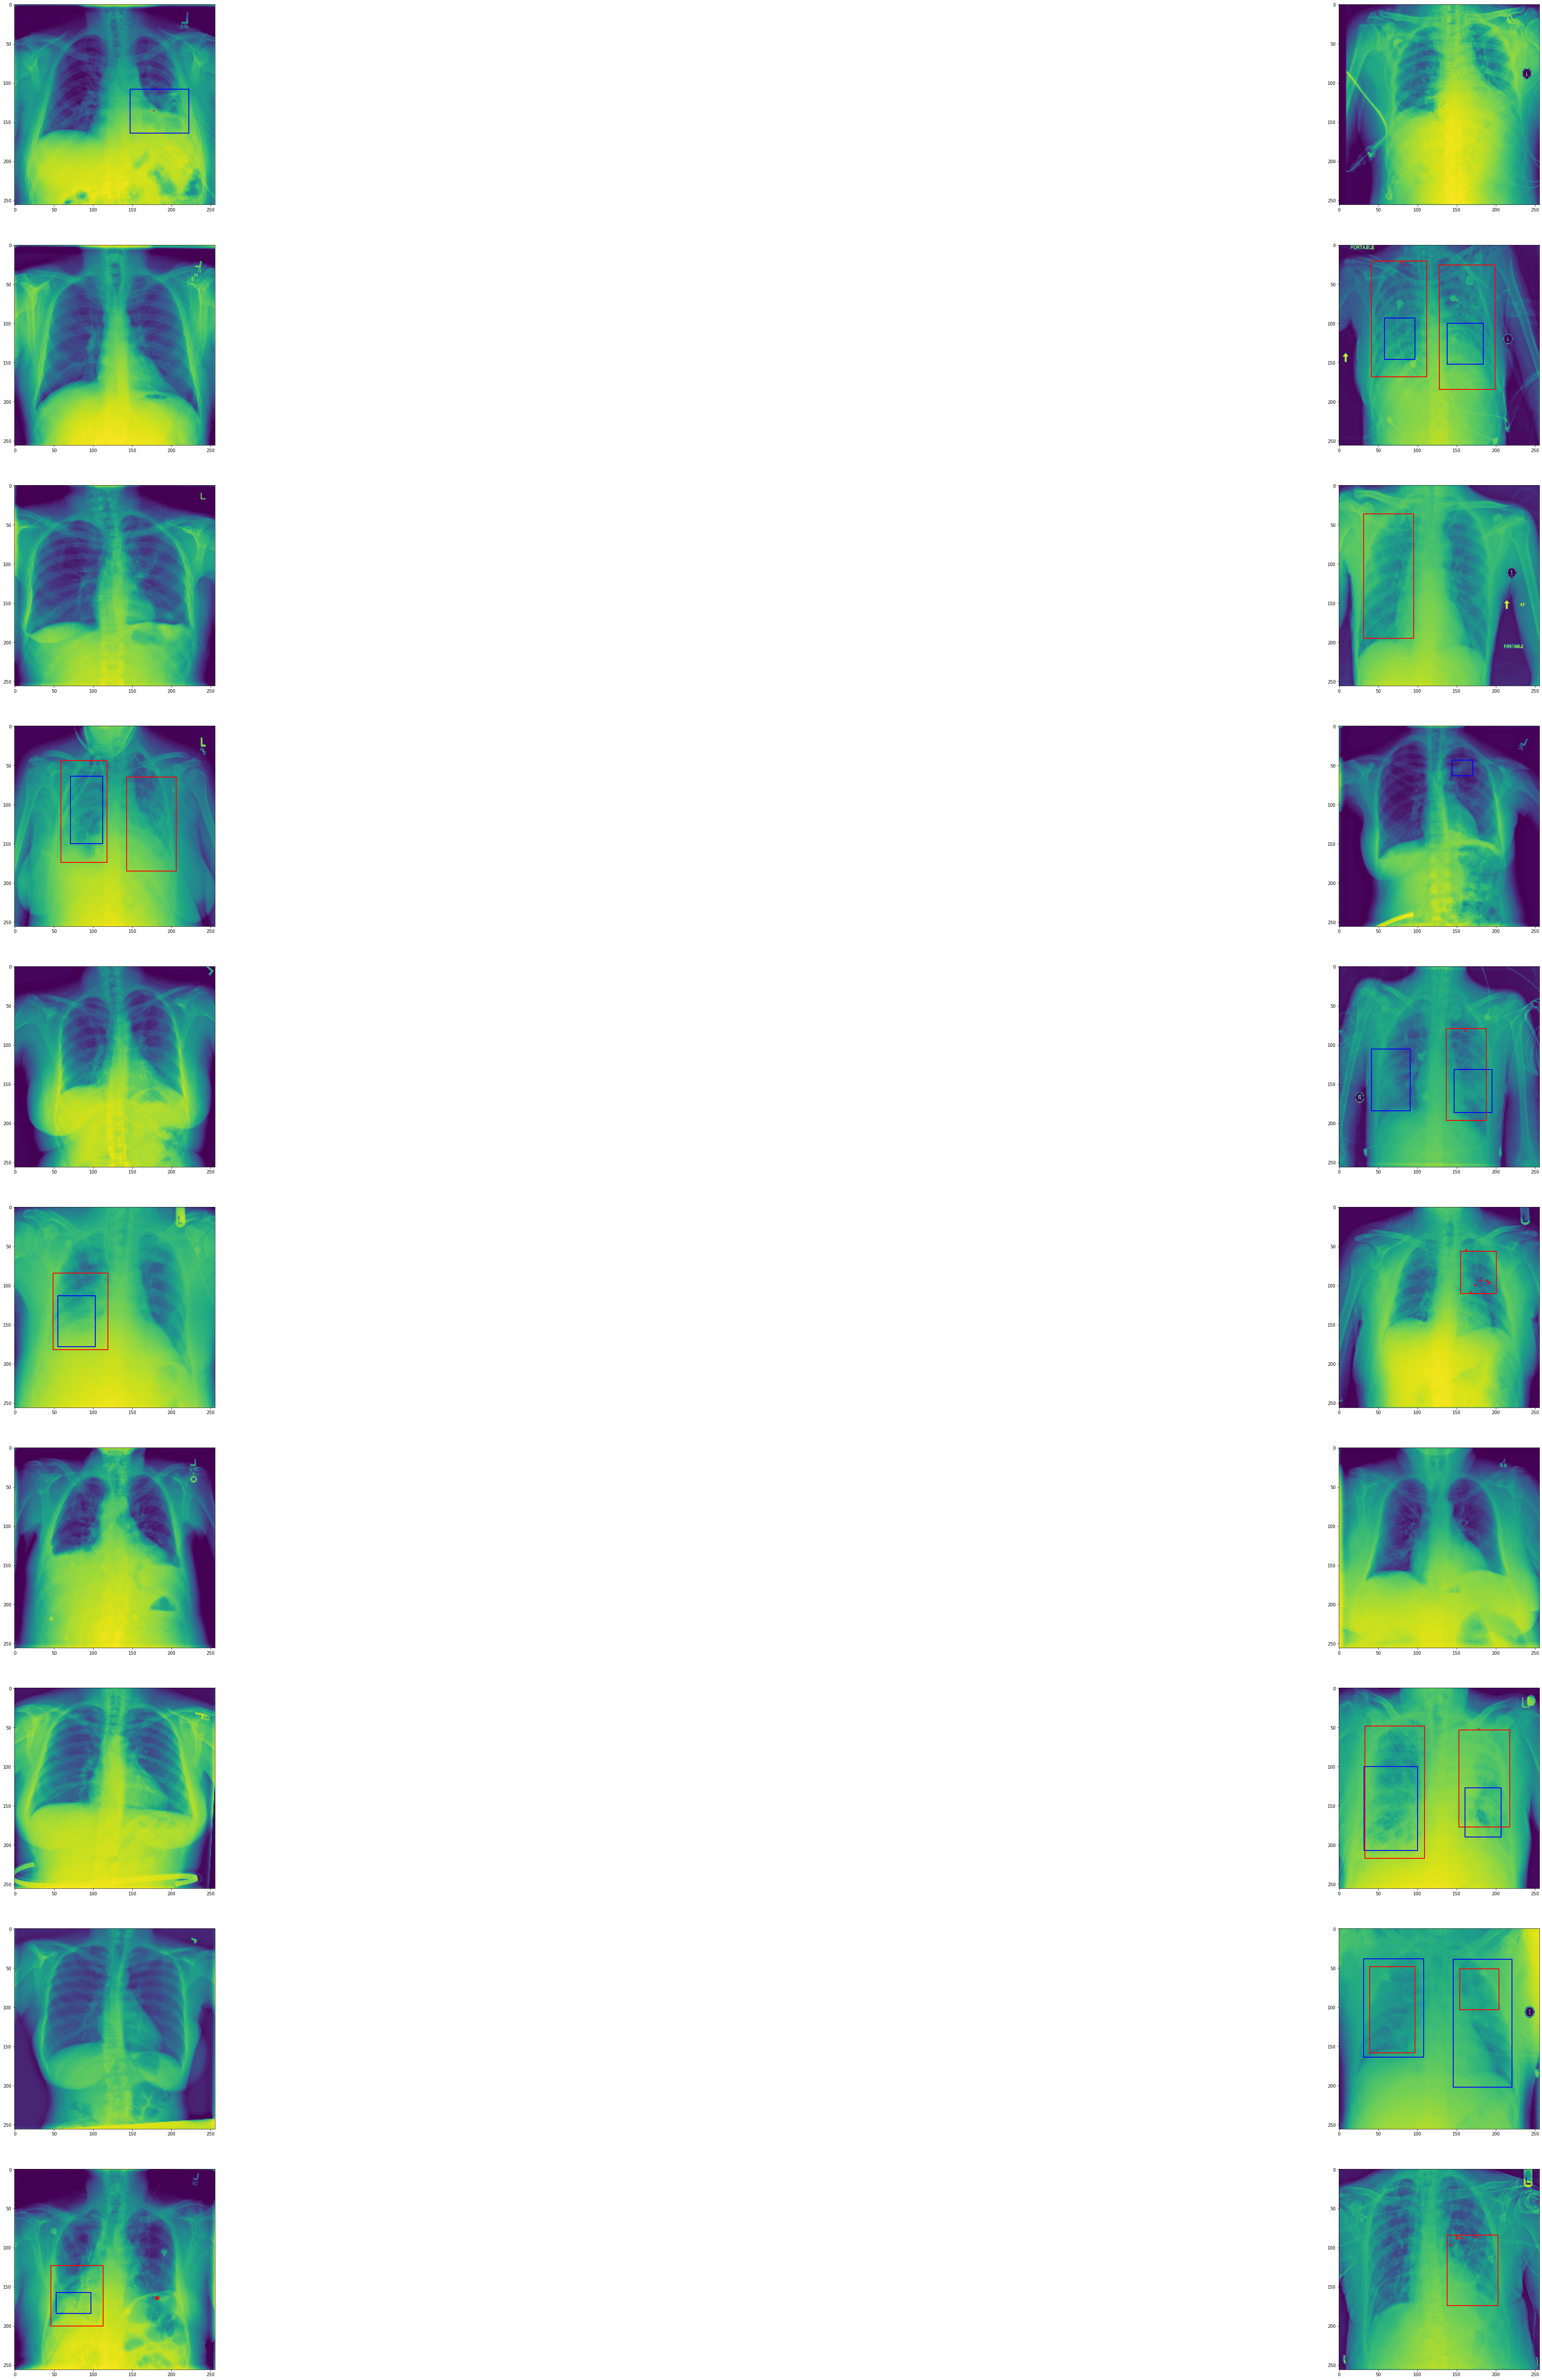

In [92]:

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for imgs, masks in valid_gen:
    # Predict a batch of images
    predictions = model.predict(imgs)
    # Create a plot for the images
    fig, axes = plt.subplots(10, 2, figsize=(100, 100))
    axes = axes.ravel()
    axidx = 0
    
    # Loop through the batch
    for img, mask, prediction in zip(imgs, masks, predictions):
        axes[axidx].imshow(img[:,:,0])
        
        # Apply threshold to true mask
        comp = mask[:,:,0] > 0.5
        
        # Apply connected components.
        comp = measure.label(comp)
        
        # Apply bounding boxes
        for region in measure.regionprops(comp):
            y1, x1, y2, x2 = region.bbox
            height = y2-y1
            width = x2-x1
            axes[axidx].add_patch(patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='b', facecolor='none'))
            
        # Apply threshold to the predicted mask
        comp = prediction[:,:,0] > 0.5
        
        # Apply connected components.
        comp = measure.label(comp)
        
        predTarget = 0
        
        # Apply bounding boxes
        for region in measure.regionprops(comp):
            # If a region is found mark the target value as 1
            predTarget = 1
            print(region.bbox)
            y1, x1, y2, x2 = region.bbox
            height = y2-y1
            width = x2-x1
            axes[axidx].add_patch(patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none'))
        
        #axes[axidx].text(0.05, 0.95, f'Actual target: \nPredicted target: {predTarget}', transform=axes[axidx].transAxes, fontsize=14, verticalalignment='top', bbox=props)
        axidx += 1
        if(axidx >= 20):
            break;
        
    plt.show()
    
    # Display only one plot per batch
    break


In [ ]:
comp

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
config = model.get_config()
model.from_config(config)

In [ ]:
path='/content/drive/My Drive/phemonia_capstone_eda/saved_model_2'
os.chdir(path)

In [ ]:
model.save(path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/phemonia_capstone_eda/saved_model_2/assets


In [ ]:
ls

assets/  saved_model.pb  variables/


In [ ]:
def f1(y_true, y_pred):
    return 1
n_model= tf.keras.models.load_model('/content/drive/My Drive/phemonia_capstone_eda/saved_model_2',custom_objects={'f1':f1})
n_model

In [ ]:
test_image_path = '/content/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm'
img = pydicom.dcmread(test_image_path).pixel_array
img = np.fliplr(img)
img = resize(img, (256,256), mode='reflect')
img = np.expand_dims(img, -1)
#imgs = np.array(img)
predict= model.predict(valid_gen)
#imgs.shape


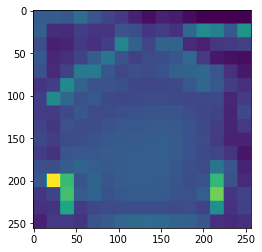

In [ ]:
0#img = resize(predict.reshape((256,256)), (256,256), mode='reflect')
plt.imshow(predict[1].squeeze())

In [ ]:
pics[1].shape

(256, 256)